# Random Coding Simulation for the BSC

The channel coding theorem is proven using random codes, i.e., codes consisting of random code words (CWs) acchieve capacity.

- This seems way to simple, can this be?

As we can not get 'better' than capacity, we can also not get 'better' than random codes.

- Why then is designing 'good' codes is an active field of research?

In [1]:
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from scipy.special import erfcinv
import matplotlib.pyplot as plt

We will simulate a binary symmetric channel (BSC) with bit flip probability `delta`. Due to limited compute resources, we say that a decoding error probability below `p_e` is sufficiently close to $0$.

To gain insights on the average behaviour, we simulate `num_codes` random codes and transmit `num_tx` CWs per code.

Each random code has $M$ random CWs and each CW is $n$ bit long. The rate of this code is $r = \frac{\log_2 M}{N}$. The $M$ values to simulate for each $n$ are listed in `n_M_options`.

Finally, `pe_per_n` contains the decoding error probabilities for each $(n,M)$-pair.

In [2]:
# Constants

delta = 0.25
p_e = 0.1

num_tx = 1000
num_codes = 100

n_M_options = {
    20: [2, 3, 4, 5],
    30: [5, 6, 7, 8, 9, 10, 11, 12],
    40: [12, 15, 18, 21, 25, 30],
    50: [30, 40, 50, 60, 70, 80],
    60: [90, 120, 150, 180, 210],
    80: [600, 900, 1200, 1600],
    100: [5000, 7000, 10000, 14000],
}

print(f'Capacity:  {1 + delta * np.log2(delta) + (1-delta) * np.log2(1-delta):.3f} (bit per channel use)')

Capacity:  0.189 (bit per channel use)


Next, define a function to simulate the effect of a BSC with bit flip probability `delta` on the CW.

In [3]:
rng = np.random.default_rng()

def bsc(code_words):
    noise = rng.binomial(1, delta, size=code_words.shape)
    return (code_words + noise) % 2

In the proof of the channel coding theorem as presented in the lecture, the decoder chooses the output message such that the CW associated with this message is jointly typical with the received sequence.

The decoder defined here decides for the output message for which the associated CW has minimum hamming distance to the received sequence. In the present case this is the optimum decoding rule (maximum likelihood decoding).

<small>To save memory the code below also splits the array `rx` of many received sequences into $100$ smaller parts and processes them sequentially.</small>

In [4]:
def decode(code, rx):
    messages = []
    for rx_part in np.array_split(rx, 100, axis=0):
        difference = (code[:, np.newaxis, :] + rx_part[np.newaxis, :, :]) % 2
        hamming_distances = np.sum(difference, axis=-1) 
        new_msgs = list(np.argmin(hamming_distances, axis=0))
        messages += new_msgs
    return np.array(messages)

The cell below creates the random codes and simulates transmissions over the BSC to estimate their decoding error probabilities. A `ProcessPoolExecutor` is used to simulate multiple codes in parallel.

In [5]:
def simulation_worker(_):
    """ Create a random code and simulate transmissions over a BSC

    returns: decoding error probability
    """
    code = rng.integers(0, 2, (M, n))

    messages = rng.integers(0, M, num_tx)
    cw = code[messages]

    rx = bsc(cw)
    rx_messages = decode(code, rx)

    return np.count_nonzero(messages != rx_messages) / num_tx

# Values precomputed on server. Commented lines will be re-simulated locally.
# NOTE: PRECOMPUTED VALUES ARE ONLY VALID IF THE CONSTANTS ABOVE ARE NOT MODIFIED!
pe_per_n = {
    # 20: [0.056444, 0.08381, 0.119539, 0.147342],
    # 30: [0.075591, 0.091745, 0.092116, 0.109378, 0.115743, 0.123867, 0.131864, 0.141782],
    # 40: [0.071264, 0.085719, 0.093049, 0.101604, 0.117425, 0.129982],
    # 50: [0.070367, 0.083284, 0.09592, 0.107604, 0.117834, 0.129224],
    # 60: [0.073359, 0.0884, 0.100816, 0.113856, 0.116424],
    80: [0.072704, 0.087088, 0.095412, 0.109976],
    100: [0.074664, 0.084912, 0.09852, 0.113672],
}

for n in n_M_options.keys():
    if n in pe_per_n:
        # Do not re-simulate precomputed values
        continue

    pe_per_n[n] = []
    print()
    for M in n_M_options[n]:
        r = np.log2(M)/n
        print(f'Code rate: log_2({M})/{n} == {r:.3f}', end=' -> ')

        error_probs = []
        with ProcessPoolExecutor() as executor:
            for error_prob in executor.map(simulation_worker, range(num_codes)):
                error_probs.append(error_prob)

        error_prob = np.mean(error_probs)
        print(f'P(error) == {error_prob:.3f}')
        pe_per_n[n].append(error_prob)


Code rate: log_2(2)/20 == 0.050 -> P(error) == 0.047
Code rate: log_2(3)/20 == 0.079 -> P(error) == 0.084
Code rate: log_2(4)/20 == 0.100 -> P(error) == 0.114
Code rate: log_2(5)/20 == 0.116 -> P(error) == 0.141

Code rate: log_2(5)/30 == 0.077 -> P(error) == 0.069
Code rate: log_2(6)/30 == 0.086 -> P(error) == 0.079
Code rate: log_2(7)/30 == 0.094 -> P(error) == 0.093
Code rate: log_2(8)/30 == 0.100 -> P(error) == 0.098
Code rate: log_2(9)/30 == 0.106 -> P(error) == 0.117
Code rate: log_2(10)/30 == 0.111 -> P(error) == 0.127
Code rate: log_2(11)/30 == 0.115 -> P(error) == 0.135
Code rate: log_2(12)/30 == 0.119 -> P(error) == 0.140

Code rate: log_2(12)/40 == 0.090 -> P(error) == 0.070
Code rate: log_2(15)/40 == 0.098 -> P(error) == 0.086
Code rate: log_2(18)/40 == 0.104 -> P(error) == 0.096
Code rate: log_2(21)/40 == 0.110 -> P(error) == 0.099
Code rate: log_2(25)/40 == 0.116 -> P(error) == 0.109
Code rate: log_2(30)/40 == 0.123 -> P(error) == 0.131

Code rate: log_2(30)/50 == 0.098 

An approximation of the acchievable rate with a given block length and acceptable error probability is given in:

Y. Polyanskiy, H. V. Poor and S. Verdu, "Channel Coding Rate in the Finite Blocklength Regime," in IEEE Transactions on Information Theory, vol. 56, no. 5, pp. 2307-2359, May 2010, doi: 10.1109/TIT.2010.2043769.

See also: 'Channel Coding -- Graph Based Codes' slides for chapter 2

In [6]:
n = np.linspace(20, 100000, 10000)
Q_inv = lambda x: np.sqrt(2) * erfcinv(2 * x)
V = delta * (1-delta) * np.log2((1-delta) / delta)**2
C = 1 + delta * np.log2(delta) + (1 - delta) * np.log2(1 - delta)
polyanskiy_approx = lambda n: C - np.sqrt(V/n) * Q_inv(p_e) + np.log2(n) / (2 * n) 

Finally, lets plot our results. We use filled circles for rates where random coding acchieves 'small' decoding error probabilities (i.e., below `p_e`). For other simulated rates, the circle stays empty. A circle is filled with gray, if the decoding error probability is close to `p_e`.

Additionally, we plot Polyanskiy's approximation in blue and the capacity as a black dashed line.

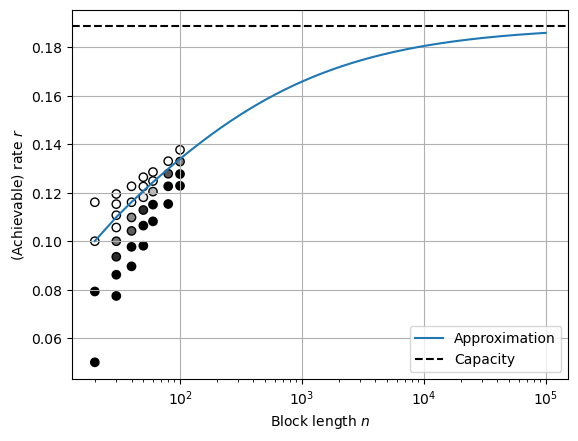

In [7]:
for n in n_M_options.keys():
    if n not in pe_per_n:
        continue

    rates = np.log2(n_M_options[n]) / n
    error_prob = pe_per_n[n]

    plt.scatter(
        np.ones(len(rates)) * n,
        rates,
        c=-np.clip(error_prob, p_e - 0.01, p_e + 0.01),
        edgecolors='k',
        marker='o',
        cmap='Greys',
    )

n = np.linspace(20, 100000, 10000)
Q_inv = lambda x: np.sqrt(2) * erfcinv(2 * x)
V = delta * (1-delta) * np.log2((1-delta) / delta)**2
C = 1 + delta * np.log2(delta) + (1 - delta) * np.log2(1 - delta)
polyanskiy_approx = lambda n: C - np.sqrt(V/n) * Q_inv(p_e) + np.log2(n) / (2 * n)

plt.plot(n, polyanskiy_approx(n), label='Approximation')
plt.gca().axhline(C, linestyle='--', color='k', label='Capacity')

plt.grid()
plt.semilogx()
plt.xlabel('Block length $n$')
plt.ylabel('(Achievable) rate $r$')
plt.legend()
plt.show()

Somewhat surprisingly the random codes really do correct errors and appear to generally follow the trajectory of Polyanskiy's approximation. <br>
$\implies$ our random codes will get close to capacity around $n\approx 10^5$

Why then put effort into designing codes?

$\implies$ Try un-commenting the lines for $n=80$ or even $n=100$.

If the full simulation is run for these block lengths (instead of using the precomputed values) it becomes very slow. We find out why by looking at the `decode()` function:
- It compares the received sequence to every CW in the code.
- A binary code of block length $n$ and rate $r$ contains $M = 2^{nr}$ CWs.
- Hence, decoding becomes computationally infeasible, even at moderate $n$.

**Example:**
- We stopped simulating at $n = 100$ and $r \approx 0.1377$ $\implies$ $M = 14000$
- $n = 200$, $r \approx 0.145$ $\implies$ $M\approx5.37\cdot10^8$
- $n = 1000$, $r\approx 0.165$ $\implies$ $M\approx4.68\cdot10^{48}$

Code design focuses on finding codes which contain structures that enamble tricks to make decoding more efficient. E.g., low-density parity-check codes have decoding complexity linear in $n$ enabling DVB-S2 to use block lengths of up to $64\,800$ (see table 5a in [the standard](https://www.etsi.org/deliver/etsi_en/302300_302399/302307/01.02.01_60/en_302307v010201p.pdf)).

<small>The issues discussed above are exponentiated if we observe that the decoding error probability of $p_e = 0.1$ seen as sufficient in this simulation is much to high for many real world applications (some of which require $p_e \leq 10^{-15}). We also use very low rates $r = 0.1..0.14$ to keep $M=2^{nr}$ small. Depending on the channel in question signifficantly higher rates are common. We have also not discussed the dificulty of storing $M=2^{nr}$ random code words.</small>